# p-value and Bayesian Hypothesis Testing

In hypothesis testing, frequentists generally use **p-value** to evaluate the evidence against the null hypothesis; **Bayesian hypothesis testing**, however, directly computes the probability of any hypothesis given observed data.

# Graphical Summary

![Fig](./graphical_summary/slides/Slide25.png)

# Key Formula

The p-value represents the probability of observing a test statistic at least as extreme as what was actually observed, assuming the null hypothesis is true.

$$
p\text{-value} = P(\text{Reject } H_0 | H_0 \text{ is true})
$$

In Bayesian hypothesis testing,

$$
P(H_i | \text{D}) = \frac{P(\text{D} | H_i) \cdot P(H_i)}{P(\text{D})}
$$


# Technical Details

## $p$-value

### Property

1. **Monotonic Relationship**: Smaller p-values correspond to more extreme test statistics
2. **Significance Level**: We reject $H_0$ if $p\text{-value} \leq \alpha$ ($\alpha$ is the significance level)


### Limitation of $p$-value

**Important**: The null hypothesis $H_0$ can never be "accepted" or "proven true" - it can only be:
- **Rejected** (when $p\text{-value} \leq \alpha$): Strong evidence against $H_0$
- **Not rejected** (when $p\text{-value} > \alpha$): Insufficient evidence to reject $H_0$, doesn't mean "accepted" or "true". Absence of evidence is not evidence of absence


### Multiple Testing

When conducting multiple hypothesis tests, the probability of making at least one Type I error (false positive) increases dramatically. Multiple testing corrections control for this inflation.

In such scenarios, multiple testing correction is necessary and it has two types of correction method:

- **Family-Wise Error Rate (FWER) Control**: control the probability of making at least one false positive across all tests

  $$
  \alpha_{\text{Bonferroni}} = \frac{\alpha}{M}
  $$

  where $M$ is the total number of tests and $\alpha$ is the desired overall significance level. For example, if previously we used 0.05 as the cutoff for 1 million tests, then after correction the cutoff becomes $5\times10^{-8}$.

- **False Discovery Rate (FDR) Control**: control the expected proportion of false positives among all discoveries (less stringent than FWER, thus more powerful). For example, Benjamini-Hochberg procedure controls the FDR by ranking $p$-values, finding largest $i$ where $p(i) \leq (\frac{i}{M}) \times \alpha$


### Permutation test

Permutation test is a simple way of obtaining null distribution of a test statistics. It answers the question: "Could I have gotten this result just by random chance?" It does this by shuffling the data many times to see what results you'd get if there were truly no real effect - just randomness. The $p$-values obtained from permutation are sometimes called *empirical $p$-values*.

**Procedure**:
1. Calculate the test statistic $T_{\text{obs}}$ on the observed data
2. Randomly permute the labels/outcomes $B$ times (typically $B=10,000$)
3. For each permutation $b$, calculate the test statistic $T_b$
4. Compute the empirical $p$-value:
   $$
   p\text{-value} = \frac{1 + \sum_{b=1}^{B} \mathbb{1}(T_b \geq T_{\text{obs}})}{B + 1}
   $$
   where $\mathbb{1}(\cdot)$ is the indicator function

**Advantages**:
- **Distribution-free**: No assumptions about the underlying distribution of test statistics
- **Exact for finite samples**: Provides exact $p$-values rather than asymptotic approximations
- **Flexible**: Can be applied to any test statistic, including complex or custom statistics. Thus it is often used when the null distribution of test statistic is unknown

**Limitations**:
- **Computationally intensive**: Requires many iterations, especially problematic for large-scale studies (e.g., GWAS with millions of tests)
- **Assumes exchangeability**: Under $H_0$, observations must be exchangeable (permuting them doesn't change the distribution)
- **Still requires multiple testing correction**: When performing many permutation tests, FWER or FDR control is still needed

## Bayesian Hypothesis Testing

In contrast, Bayesian hypothesis testing is a lot easier to interpret, it simply means the probability of accepting the hypothesis given the observed data.

## Frequentist vs. Bayesian Paradigms

**The fundamental question**: What does probability mean?

**Frequentist ($p$-value)**:
- Probability = long-run frequency over repeated experiments
- Parameters are fixed; data varies across hypothetical repetitions
- Answers: $P(\text{Data} \mid H_0)$ — "How extreme is my data if $H_0$ were true?"
- **Cannot say**: "Probability that $H_0$ is true"

**Bayesian (Posterior probability)**:
- Probability = degree of belief/uncertainty
- Parameters vary; observed data is fixed
- Answers: $P(H_0 \mid \text{Data})$ — "How probable is $H_0$ given my data?"
- **Can say**: "There's a 95% probability the parameter is in this interval"

**Multiple testing**: Frequentists require explicit corrections (Bonferroni, FDR); Bayesians incorporate prior beliefs that naturally regularize.

# Related Topics

- [ordinary least squares](https://statfungen.github.io/statgen-primer/ordinary_least_squares.html)
- [summary statistics](https://statfungen.github.io/statgen-primer/summary_statistics.html)
- [likelihood](https://statfungen.github.io/statgen-primer/likelihood.html)
- [Bayes factor](https://statfungen.github.io/statgen-primer/Bayes_factor.html)

# Example

QTL analysis tries to answer the question of **"Which genetic variants (SNPs) are associated with gene expression levels?"**.

We'll demonstrate this with a simple example:
- Multiple individuals with genotype data at several SNP variants
- Gene expression measurements for a single gene
- Testing each SNP for association with expression
- Controlling for multiple testing using different approaches

Let's start with a realistic scenario: we have genotype data for 200 individuals at 15 SNPs in a region of interest, and we measure expression of a target gene.

In [55]:
rm(list=ls())
set.seed(83)

# Parameters for simulation
n_samples <- 200      # Number of individuals
n_snps <- 25          # Number of SNPs to test
n_true_snps <- 2      # Number of SNPs truly associated with expression

# Simulate genotypes with Linkage Disequilibrium (LD)
# Strategy: Create a causal founder haplotype and introduce recombination
# to create LD structure between nearby variants

cat("Simulating genotypes with Linkage Disequilibrium (LD)...\n")

# Start with a founder haplotype (allele frequencies)
allele_freqs <- runif(n_snps, 0.2, 0.8)

# Create two haplotypes (two copies per individual)
# We'll use a simple LD model: nearby SNPs are correlated
haplotype1 <- matrix(NA, nrow = n_samples, ncol = n_snps)
haplotype2 <- matrix(NA, nrow = n_samples, ncol = n_snps)

# Generate first SNP independently
haplotype1[, 1] <- rbinom(n_samples, size = 1, prob = allele_freqs[1])
haplotype2[, 1] <- rbinom(n_samples, size = 1, prob = allele_freqs[1])

# For subsequent SNPs, create LD with previous SNP
# LD correlation parameter (higher = stronger LD)
ld_rho <- 0.8  # Correlation parameter for LD (range 0-1, higher = stronger LD)

for(i in 2:n_snps) {
  # Each SNP is correlated with the previous one
  # With probability (1-rho), SNP changes from previous; with probability rho, stays same
  
  # Haplotype 1: LD with SNP i-1
  haplotype1[, i] <- haplotype1[, i-1]  # Start with previous SNP allele
  # Randomly flip some alleles to create variation
  flip_idx1 <- runif(n_samples) > ld_rho
  haplotype1[flip_idx1, i] <- 1 - haplotype1[flip_idx1, i]
  
  # Haplotype 2: LD with SNP i-1 (independent from haplotype 1)
  haplotype2[, i] <- haplotype2[, i-1]  # Start with previous SNP allele
  flip_idx2 <- runif(n_samples) > ld_rho
  haplotype2[flip_idx2, i] <- 1 - haplotype2[flip_idx2, i]
}

# Combine haplotypes to get diploid genotypes (0, 1, or 2 alternate alleles)
genotypes <- haplotype1 + haplotype2

colnames(genotypes) <- paste0("SNP_", 1:n_snps)

cat("Simulated genotype matrix with LD structure:\n")
cat("Dimensions:", nrow(genotypes), "samples x", ncol(genotypes), "SNPs\n")
cat("LD correlation parameter (rho):", ld_rho, "\n")
cat("First few rows:\n")
head(genotypes)

# Calculate and display LD structure (correlation matrix)
ld_matrix <- cor(genotypes)

Simulating genotypes with Linkage Disequilibrium (LD)...
Simulated genotype matrix with LD structure:
Dimensions: 200 samples x 25 SNPs
LD correlation parameter (rho): 0.8 
First few rows:


SNP_1,SNP_2,SNP_3,SNP_4,SNP_5,SNP_6,SNP_7,SNP_8,SNP_9,SNP_10,⋯,SNP_16,SNP_17,SNP_18,SNP_19,SNP_20,SNP_21,SNP_22,SNP_23,SNP_24,SNP_25
0,0,0,0,0,0,0,1,1,1,⋯,1,1,2,2,0,1,2,1,2,1
1,2,1,1,1,1,1,0,0,0,⋯,0,0,0,0,1,2,2,2,2,2
0,0,1,1,0,1,1,1,1,2,⋯,1,2,2,1,1,1,0,0,0,0
1,2,2,0,1,1,0,0,0,0,⋯,1,1,1,1,1,1,1,1,0,0
0,0,0,1,2,2,2,2,2,2,⋯,0,0,1,1,0,0,1,1,1,0
1,2,1,1,1,0,0,0,0,0,⋯,0,1,1,0,0,0,1,1,2,1


Now we simulate expression levels. We'll make **SNP1 and SNP2 truly associated with expression** (with effect sizes), and the other SNPs have no real association. The expression will also include random noise.

In [56]:
# Simulate expression: true effects from SNP_1 and SNP_2, plus noise
# Expression = effect1*SNP1 + effect2*SNP2 + noise

effect_snp1 <- 1.5     # Effect size for SNP_1
effect_snp2 <- 1.2     # Effect size for SNP_2

expression <- effect_snp1 * genotypes[, 1] + 
              effect_snp2 * genotypes[, 2] + 
              rnorm(n_samples, mean = 0, sd = 2)

cat("Simulated expression data (n =", n_samples, "samples):\n")
cat("True effects: SNP_1 (effect =", effect_snp1, ") and SNP_2 (effect =", effect_snp2, ")\n")
cat("Mean expression:", round(mean(expression), 2), "\n")
cat("SD expression:", round(sd(expression), 2), "\n")
cat("First few samples:\n")
cbind(genotypes[1:5, 1:5], expression = expression[1:5])


Simulated expression data (n = 200 samples):
True effects: SNP_1 (effect = 1.5 ) and SNP_2 (effect = 1.2 )
Mean expression: 1.83 
SD expression: 2.29 
First few samples:


SNP_1,SNP_2,SNP_3,SNP_4,SNP_5,expression
0,0,0,0,0,1.4516029
1,2,1,1,1,6.6169700
0,0,1,1,0,4.8286530
1,2,2,0,1,4.1347712
0,0,0,1,2,0.2250084


We first perform the marginal effect of each variant:

In [57]:
# Test each SNP for association with expression
# Perform linear regression: expression ~ genotype for each SNP

p_values <- numeric(n_snps)
effect_sizes <- numeric(n_snps)
test_statistics <- numeric(n_snps)

# Loop through each SNP and test for association
for(i in 1:n_snps) {
  # Fit linear regression model: expression ~ genotype
  model <- lm(expression ~ genotypes[, i])
  
  # Extract p-value from the slope coefficient test
  # (We want the p-value for the SNP effect, not the intercept)
  summary_model <- summary(model)
  p_values[i] <- summary_model$coefficients[2, 4]  # p-value of SNP coefficient
  effect_sizes[i] <- summary_model$coefficients[2, 1]  # effect size (slope)
  test_statistics[i] <- summary_model$coefficients[2, 3]  # t-statistic
}

# Create a results table
results <- data.frame(
  SNP = colnames(genotypes),
  Effect = effect_sizes,
  T_statistic = test_statistics,
  P_value = p_values,
  Minus_log10_P = -log10(p_values)
)

cat("Association test results for all SNPs:\n")
results

Association test results for all SNPs:


SNP,Effect,T_statistic,P_value,Minus_log10_P
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
SNP_1,1.93449131,7.6451924,8.827948e-13,12.05414024
SNP_2,1.36793160,6.3769180,1.247657e-09,8.90390462
SNP_3,0.51383262,2.2170445,2.775781e-02,1.55661483
SNP_4,0.39898620,1.6581493,9.887071e-02,1.00493233
SNP_5,0.08025969,0.3528669,7.245636e-01,0.13992350
SNP_6,0.21135756,0.8837714,3.778914e-01,0.42263295
SNP_7,0.30456995,1.3741282,1.709554e-01,0.76711727
SNP_8,0.25950796,1.1682952,2.440925e-01,0.61244556
SNP_9,-0.03794598,-0.1692696,8.657574e-01,0.06260378


In [58]:
results[results$P_value < 0.05, ]

,SNP,Effect,T_statistic,P_value,Minus_log10_P
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,SNP_1,1.9344913,7.645192,8.827948e-13,12.054140
2,SNP_2,1.3679316,6.376918,1.247657e-09,8.903905
3,SNP_3,0.5138326,2.217044,2.775781e-02,1.556615


Now let's try to control for multiple testing by using the Bonferroni Correction, which adjusts the threshold to $\frac{\alpha}{M} = \frac{0.05}{15}$.

In [59]:
# Apply Bonferroni correction
# Bonferroni threshold: alpha / M
alpha <- 0.05
bonferroni_threshold <- alpha / n_snps

# Identify significant SNPs under Bonferroni correction
bonferroni_sig <- results$P_value < bonferroni_threshold

cat("Bonferroni Correction (alpha = 0.05)\n")
cat("=========================================\n")
cat("Adjusted significance threshold:", bonferroni_threshold, "\n")
cat("Number of significant SNPs:", sum(bonferroni_sig), "\n")
cat("\nSignificant SNPs under Bonferroni:\n")
if(sum(bonferroni_sig) > 0) {
  results[bonferroni_sig, ]
} else {
  cat("(None)\n")
}

Bonferroni Correction (alpha = 0.05)
Adjusted significance threshold: 0.002 
Number of significant SNPs: 2 

Significant SNPs under Bonferroni:


,SNP,Effect,T_statistic,P_value,Minus_log10_P
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,SNP_1,1.934491,7.645192,8.827948e-13,12.054140
2,SNP_2,1.367932,6.376918,1.247657e-09,8.903905


Note that after applying Bonferroni correction, the number of significant variants decreases.

We can also use FDR to control the expected proportion of false positives among discoveries, allowing us to find more true associations while still controlling error.

In [60]:
# Apply Benjamini-Hochberg FDR control
# Steps:
# 1. Sort p-values
# 2. Find largest i where p(i) <= (i/M) * alpha
# 3. Reject all hypotheses up to index i

# Sort p-values and get indices
sorted_indices <- order(results$P_value)
sorted_pvals <- results$P_value[sorted_indices]

# Find the largest i where p(i) <= (i/M) * alpha_FDR
alpha_fdr <- 0.05
thresholds <- (1:n_snps / n_snps) * alpha_fdr
cutoff_idx <- max(which(sorted_pvals <= thresholds))

# If no SNP passes, cutoff_idx will be -Inf
if(is.na(cutoff_idx) || is.infinite(cutoff_idx)) {
  cutoff_idx <- 0
  fdr_threshold <- 0
} else {
  fdr_threshold <- sorted_pvals[cutoff_idx]
}

# Compute q-values (adjusted p-values for FDR)
# q-value for each test = min(p * M / rank, 1)
q_values <- numeric(n_snps)
for(i in 1:n_snps) {
  rank_i <- which(sorted_indices == i)
  q_values[i] <- min(results$P_value[i] * n_snps / rank_i, 1)
}

results$Q_value <- q_values
fdr_sig <- results$Q_value < alpha_fdr

cat("Benjamini-Hochberg FDR Control (alpha = 0.05)\n")
cat("=========================================\n")
cat("FDR threshold:", fdr_threshold, "\n")
cat("Number of significant SNPs:", sum(fdr_sig), "\n")
cat("\nSignificant SNPs under FDR:\n")
if(sum(fdr_sig) > 0) {
  results[fdr_sig, c("SNP", "Effect", "P_value", "Q_value")]
} else {
  cat("(None)\n")
}

Benjamini-Hochberg FDR Control (alpha = 0.05)
FDR threshold: 1.247657e-09 
Number of significant SNPs: 2 

Significant SNPs under FDR:


,SNP,Effect,P_value,Q_value
,<chr>,<dbl>,<dbl>,<dbl>
1,SNP_1,1.934491,8.827948e-13,2.206987e-11
2,SNP_2,1.367932,1.247657e-09,1.559572e-08


## Permutation Testing for eGene Discovery

Now we demonstrate permutation testing to control FDR for eGene (expression quantitative trait locus) discovery. The key idea: for each gene, we find the minimum p-value across all SNPs. We then shuffle sample labels to generate a null distribution, and compute empirical p-values.

In [61]:
# Observed test statistic: minimum p-value across all SNPs
# This is what we would report as the eGene p-value
min_pval_observed <- min(p_values)

cat("Observed minimum p-value (across all SNPs):", min_pval_observed, "\n")
cat("This represents the 'eGene signal' for this gene.\n\n")

# Now perform permutations to get null distribution
n_perms <- 1000  # Number of permutations (use more for real studies, e.g., 10,000)

# Store minimum p-values from each permutation
min_pvals_permuted <- numeric(n_perms)

set.seed(27)  # For reproducibility

cat("Running", n_perms, "permutations...\n")

for(perm in 1:n_perms) {
  # Shuffle the expression labels (break association with genotypes)
  # This shuffles the sample order of expression, so each SNP is tested
  # against a random expression ordering
  expression_shuffled <- expression[sample(n_samples)]
  
  # Test each SNP against shuffled expression
  pvals_perm <- numeric(n_snps)
  for(i in 1:n_snps) {
    model <- lm(expression_shuffled ~ genotypes[, i])
    summary_model <- summary(model)
    pvals_perm[i] <- summary_model$coefficients[2, 4]
  }
  
  # Store minimum p-value from this permutation
  min_pvals_permuted[perm] <- min(pvals_perm)
}

cat("Permutation test completed.\n\n")

Observed minimum p-value (across all SNPs): 8.827948e-13 
This represents the 'eGene signal' for this gene.

Running 1000 permutations...


Permutation test completed.



Empirical p-value from permutations: 0.000999001 
Interpretation: probability of seeing a minimum p-value this small by chance



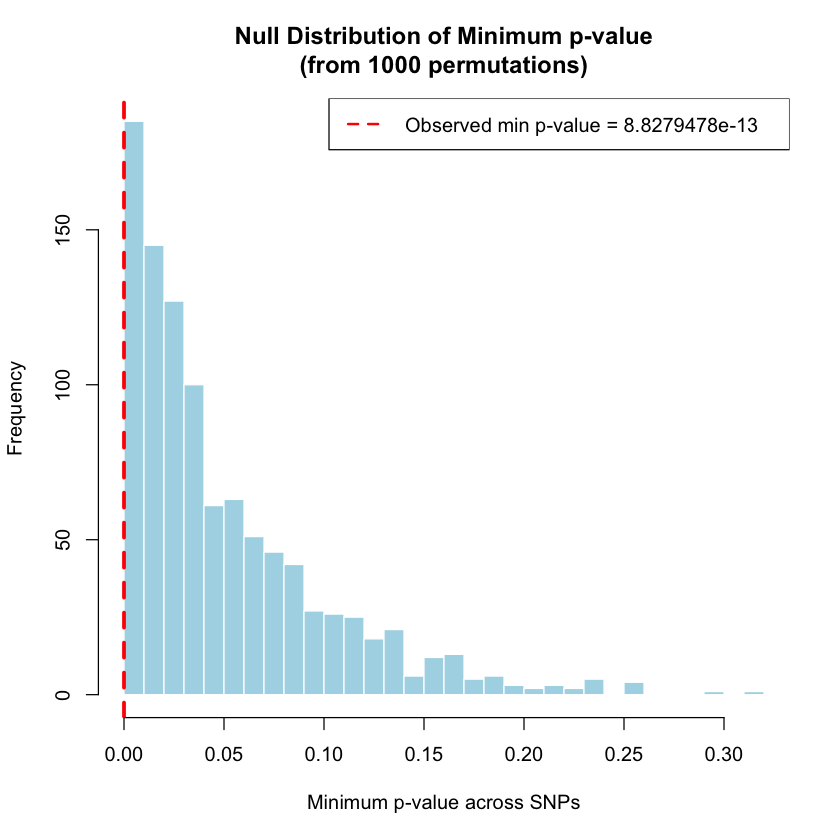

In [62]:
# Calculate empirical p-value
# p-value = (1 + # permutations with test stat >= observed) / (n_perms + 1)
empirical_pval <- (1 + sum(min_pvals_permuted <= min_pval_observed)) / (n_perms + 1)

cat("Empirical p-value from permutations:", empirical_pval, "\n")
cat("Interpretation: probability of seeing a minimum p-value this small by chance\n\n")

# Visualize the null distribution
hist(min_pvals_permuted, 
     breaks = 30,
     main = paste0("Null Distribution of Minimum p-value\n(from ", n_perms, " permutations)"),
     xlab = "Minimum p-value across SNPs",
     ylab = "Frequency",
     col = "lightblue",
     border = "white")

# Add line for observed minimum p-value
abline(v = min_pval_observed, col = "red", lwd = 3, lty = 2)
legend("topright", 
       legend = paste("Observed min p-value =", round(min_pval_observed, 20)),
       col = "red", lty = 2, lwd = 2)


## Extending to Genome-Wide Study: Multiple Genes and FDR Control

**Summary of what we just did for ONE gene:**
- Tested 25 SNPs for association with expression
- Used minimum p-value (min p = 8.8e-13) as the test statistic for this gene
- Ran 1,000 permutations to generate null distribution
- Computed empirical p-value showing this gene is a significant **eGene**

**In a real genome-wide study**, we would repeat this permutation test for many genes (e.g., 100, 1000, or 10,000 genes), getting one empirical p-value per gene. Then we need to control for the multiple testing problem across genes using FDR.

Let's simulate what happens in a multi-gene study:

In [63]:
# Simulate a genome-wide eQTL study with 100 genes
# In reality, each gene would have its own permutation test done separately

n_genes <- 100  # Number of genes tested genome-wide

# Our analyzed gene has this empirical p-value from permutations:
our_gene_pval <- empirical_pval

cat("Genome-wide FDR control for eGene discovery:\n")
cat("=========================================\n\n")
cat("Our gene (Gene_1) empirical p-value:", format(our_gene_pval, scientific=TRUE), "\n\n")

# Simulate empirical p-values for 99 other genes
# In reality, each would have its own permutation test
# Most genes have no eQTL signal (p-values close to 0.5)
# A few have real signals (p-values close to 0)
set.seed(72)
other_genes_pval <- rbeta(n_genes - 1, shape1 = 1, shape2 = 5)

# Combine: our gene + other genes
all_genes_pval <- c(our_gene_pval, other_genes_pval)
gene_names <- paste0("Gene_", 1:n_genes)

cat("Summary of empirical p-values across", n_genes, "genes:\n")
cat("- Smallest p-value:", format(min(all_genes_pval), scientific=TRUE), "\n")
cat("- Median p-value:", round(median(all_genes_pval), 4), "\n")
cat("- Largest p-value:", round(max(all_genes_pval), 4), "\n\n")


Genome-wide FDR control for eGene discovery:

Our gene (Gene_1) empirical p-value: 9.99001e-04 

Summary of empirical p-values across 100 genes:
- Smallest p-value: 4.125328e-04 
- Median p-value: 0.1206 
- Largest p-value: 0.5724 



Now let's apply FDR control on the gene level.

In [64]:
# Apply FDR control (Benjamini-Hochberg) to empirical p-values
# This controls the expected proportion of false positive eGenes
sorted_idx <- order(all_genes_pval)
sorted_pval <- all_genes_pval[sorted_idx]
sorted_genes <- gene_names[sorted_idx]

# Find largest i where p(i) <= (i/M) * alpha
alpha_fdr_genes <- 0.05
thresholds_genes <- (1:n_genes / n_genes) * alpha_fdr_genes

# Find which genes pass the threshold
sig_idx <- which(sorted_pval <= thresholds_genes)

if(length(sig_idx) > 0) {
  n_sig_genes <- max(sig_idx)
  fdr_cutoff_genes <- sorted_pval[n_sig_genes]
} else {
  n_sig_genes <- 0
  fdr_cutoff_genes <- 0
}

# Compute q-values for all genes (FDR-adjusted p-values)
# q-value: the smallest FDR threshold at which this gene is called significant
q_values_genes <- numeric(n_genes)
for(i in 1:n_genes) {
  rank_i <- which(sorted_idx == i)
  q_values_genes[i] <- min(all_genes_pval[i] * n_genes / rank_i, 1)
}

# Create results table
genome_results <- data.frame(
  Gene = gene_names,
  Empirical_Pvalue = all_genes_pval,
  Q_value = q_values_genes,
  Is_eGene = q_values_genes < alpha_fdr_genes
)

cat("Results: Significant eGenes (q-value < 0.05):\n")
cat("=========================================\n")
egenes <- genome_results[genome_results$Is_eGene, ]
if(nrow(egenes) > 0) {
  print(egenes)
  cat("\nTotal significant eGenes:", nrow(egenes), "\n")
} else {
  cat("(None found)\n")
}

cat("\nInterpretation:\n")
cat("- Among", n_genes, "genes tested, we found", nrow(egenes), "significant eGenes\n")
cat("- At FDR 0.05, we expect ~5% of these", nrow(egenes), "discoveries to be false positives\n")
cat("- Our analyzed gene (Gene_1) is", ifelse(any(egenes$Gene == "Gene_1"), "significant", "NOT significant"), "\n")


Results: Significant eGenes (q-value < 0.05):
      Gene Empirical_Pvalue    Q_value Is_eGene
1   Gene_1     0.0009990010 0.04995005     TRUE
34 Gene_34     0.0004125328 0.04125328     TRUE

Total significant eGenes: 2 



Interpretation:
- Among 100 genes tested, we found 2 significant eGenes
- At FDR 0.05, we expect ~5% of these 2 discoveries to be false positives
- Our analyzed gene (Gene_1) is significant 


Note that the results of gene 2-100 are artifact in this case, only to present the complete process of performing permutation test for eGene discovery.

# Supplementary

## Graphical Summary

### p-value: Right Tail Probability

Visualizing the p-value as the area in the right tail of the null distribution:

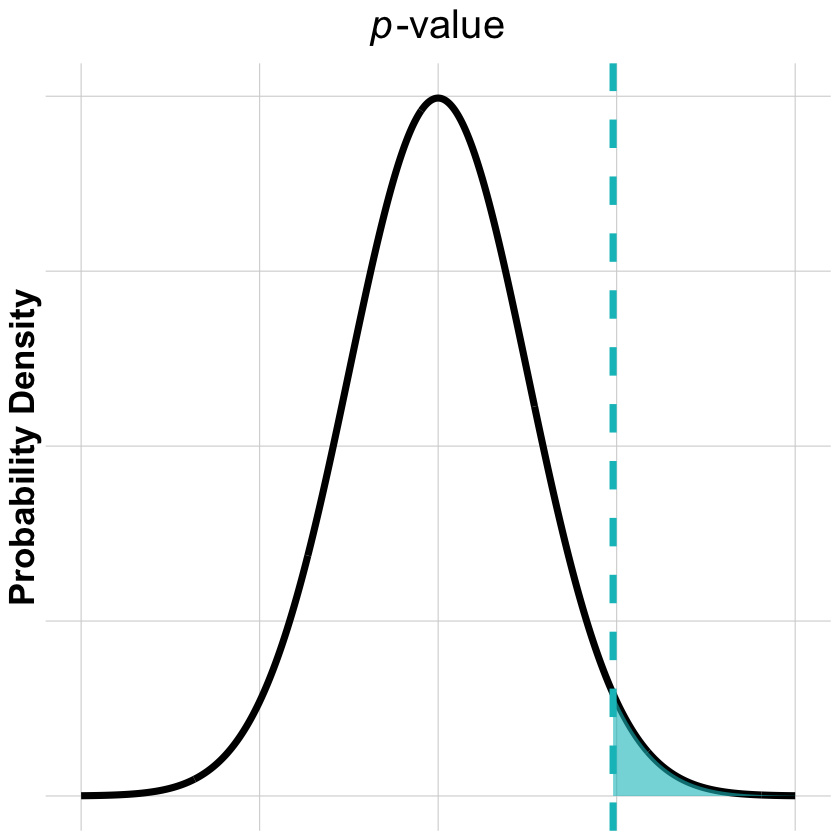

In [ ]:
library(ggplot2)
library(tibble)
# Create data for a normal distribution curve
x_range <- seq(-4, 4, by = 0.01)
curve_data <- tibble(x = x_range, density = dnorm(x_range, mean = 0, sd = 1))
# Define the vertical line position (e.g., at x = 1.96 for a typical significance level)
line_pos <- 1.96
# Create data for the shaded area (from line to the right)
shade_data <- curve_data[curve_data$x >= line_pos, ]
# Create the plot
p_value_plot <- ggplot(curve_data, aes(x = x, y = density)) +
  geom_line(color = "black", linewidth = 2) +
  geom_area(data = shade_data, fill = "#00BFC4", alpha = 0.6) +
  geom_vline(xintercept = line_pos, color = "#00BFC4", linewidth = 2, linetype = "dashed") +
  labs(
    title = expression(italic(p)*"-value"),
    y = "Probability Density"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 24, face = "bold", hjust = 0.5),
    axis.title.x = element_blank(),
    axis.title.y = element_text(size = 21, face = "bold"),
    axis.text = element_blank(),
    legend.position = "top",
    legend.title = element_text(size = 23, face = "bold"),
    legend.text = element_text(size = 22, face = "bold"),
    panel.grid.major = element_line(color = "lightgray", size = 0.3),
    panel.grid.minor = element_blank(),
    panel.background = element_rect(fill = "transparent", color = NA),
    plot.background = element_rect(fill = "transparent", color = NA)
  )

print(p_value_plot)
ggsave("./cartoons/p_value.png", plot = p_value_plot, width = 12, height = 6, 
       units = "in", dpi = 300, bg = "transparent")

### Bayesian Hypothesis Testing

In Bayesian hypothesis testing, we compare two hypotheses by calculating their posterior probabilities given the observed data. Below we visualize this with two overlapping normal distributions:

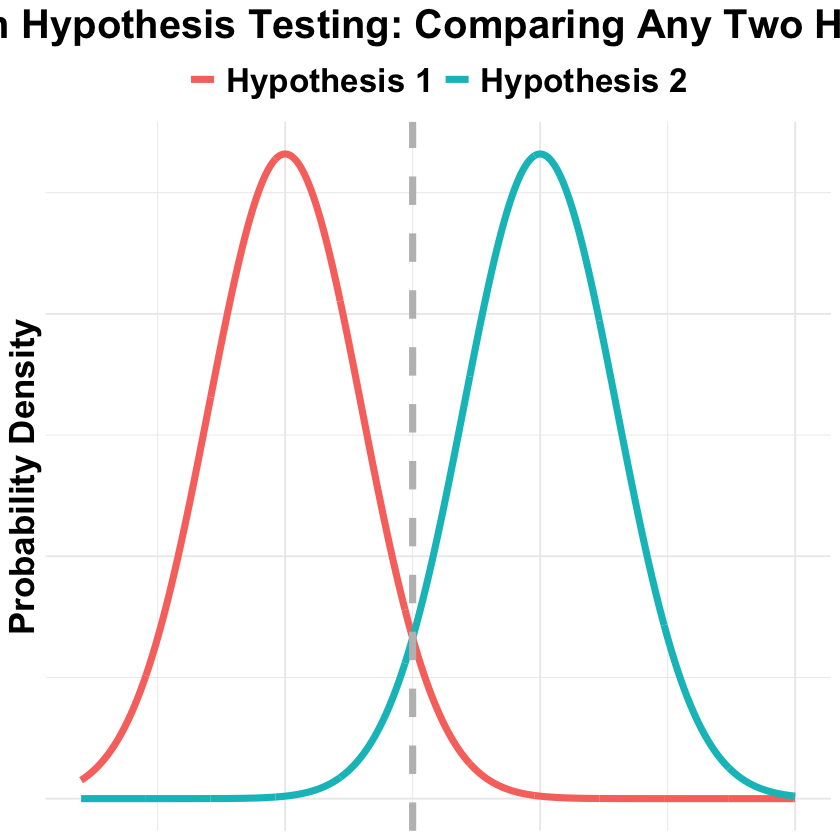

In [101]:
library(ggplot2)
library(tibble)

# Create data for two hypothesis
x_range <- seq(-4, 10, by = 0.01)

h0_data <- tibble(
  x = x_range,
  density = dnorm(x_range, mean = 0, sd = 1.5),
  hypothesis = "Hypothesis 1"
)

h1_data <- tibble(
  x = x_range,
  density = dnorm(x_range, mean = 5, sd = 1.5),
  hypothesis = "Hypothesis 2"
)

line_pos = (0+5)/2
bayes_data <- rbind(h0_data, h1_data)

# Create the plot
p_Bayesian_hypothesis_testing <- ggplot(bayes_data, aes(x = x, y = density, color = hypothesis)) +
  geom_line(size = 2) +
  geom_vline(xintercept = line_pos, color = "grey", linewidth = 2, linetype = "dashed") +
  labs(
    title = "Bayesian Hypothesis Testing: Comparing Any Two Hypotheses",
    x = "Test Statistic",
    y = "Probability Density",
    color = NULL
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 24, face = "bold", hjust = 0.5),
    axis.title = element_text(size = 21, face = "bold"),
    axis.title.x = element_blank(),
    axis.text = element_blank(),
    legend.position = "top",
    legend.title = element_text(size = 24, face = "bold"),
    legend.text = element_text(size = 20, face = "bold"),
    panel.background = element_rect(fill = "transparent", color = NA),
    plot.background = element_rect(fill = "transparent", color = NA)
  )

print(p_Bayesian_hypothesis_testing)
ggsave("./cartoons/Bayesian_hypothesis_testing.png", plot = p_Bayesian_hypothesis_testing, width = 12, height = 6,
       units = "in", dpi = 300, bg = "transparent")


### Multiple Testing

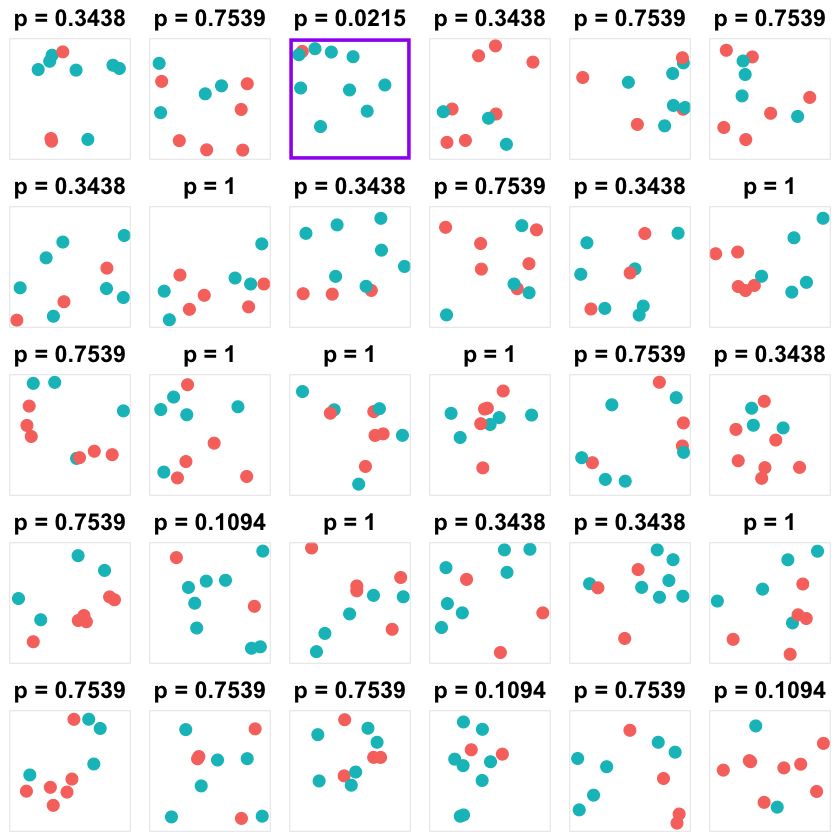

In [83]:
library(ggplot2)
library(tibble)
library(gridExtra)

# Set seed for reproducibility
set.seed(71)

# Function to generate random sample of 10 dots (blue or red with equal probability)
generate_sample <- function(n = 10) {
  tibble(
    x = runif(n, 0, 1),
    y = runif(n, 0, 1),
    color = sample(c("red", "blue"), n, replace = TRUE, prob = c(0.5, 0.5))
  )
}

# Function to calculate p-value using binomial test
calc_binomial_pvalue <- function(data) {
  n_blue <- sum(data$color == "blue")
  n_total <- nrow(data)
  # Two-tailed binomial test
  binom.test(n_blue, n_total, p = 0.5, alternative = "two.sided")$p.value
}

# Generate 30 samples
n_samples <- 30
sample_list <- list()

for (i in 1:n_samples) {
  data <- generate_sample(n = 10)
  pval <- calc_binomial_pvalue(data)
  sample_list[[i]] <- list(data = data, pval = pval)
}

# Create a grid of plots
plot_list <- lapply(1:n_samples, function(i) {
  data <- sample_list[[i]]$data
  pval <- sample_list[[i]]$pval
  
  # Count blue and red
  n_blue <- sum(data$color == "blue")
  n_red <- sum(data$color == "red")
  
  # Format p-value
  pval_text <- paste0("p = ", round(pval, 4))
  
  # Highlight significant comparisons (p < 0.05)
  border_color <- if (pval < 0.05) "purple" else "gray90"
  border_size <- if (pval < 0.05) 2 else 0.5
  
  ggplot(data, aes(x = x, y = y, color = color)) +
    geom_point(size = 3) +
    scale_color_manual(values = c("red" = "#F8766D", "blue" = "#00BFC4")) +
    labs(title = pval_text) +
    theme_void() +
    theme(
      plot.title = element_text(size = 14, hjust = 0.5, face = "bold", margin = margin(b = 5)),
      legend.position = "none",
      panel.border = element_rect(color = border_color, fill = NA, linewidth = border_size),
      plot.background = element_rect(fill = "transparent", color = NA),
      panel.background = element_rect(fill = "transparent", color = NA),
      plot.margin = margin(5, 5, 5, 5)
    ) +
    coord_fixed(xlim = c(0, 1), ylim = c(0, 1))
})

# Arrange in a grid (5 rows x 6 columns)
grid_plot <- grid.arrange(grobs = plot_list, ncol = 6)

# Save
ggsave("./cartoons/multiple_testing.png", plot = grid_plot, 
       width = 18, height = 10, units = "in", dpi = 300, bg = "transparent")

# Extended Reading

- [Connection between Bayes factor and p-value](https://stephens999.github.io/fiveMinuteStats/BF_and_pvalue.html)
- [Example of difficulty of calibrating p values](https://stephens999.github.io/fiveMinuteStats/pvalue_difficult_calibrate_example.html)